In [1]:
import numpy as np
import argparse
import csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)
import pandas as pd
import math
import random

In [15]:
LEARNING_RATE = 0.003
BATCH_SIZE = 64
NUM_ITER = 50000
MAX_POWER = 9
SUBSET = 100
SPLIT = 0.9
ERROR = "mse"
REGULARIZATION_LAMBDA = 0

In [3]:
def readDataLink(filename):
    dataset = []
    df = pd.read_csv(filename,header=None)
    for i,row in df.iterrows():
        dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readDataLink('https://web.iitd.ac.in/~sumeet/A1/2019EE10577/gaussian.csv')

In [57]:
def readData(filename):
    dataset = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readData('gaussian.csv')

In [4]:
dataset = dataset[:SUBSET]

In [4]:
# highest power is m here
def makeDesignMat(x,m):
    return np.vander(x,m+1,increasing=True)

In [5]:
def chunkarr(arr,n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [6]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g")
    plt.plot(xa,test_err_list,color="r")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.show()

In [7]:
def descent(trainX,y,testX,testY,lambd = 0.0, err_function = "mse" ):
    w = np.zeros(MAX_POWER+1)
    bestw = np.zeros(MAX_POWER+1)
    y = np.array(y)
    X = makeDesignMat(trainX,MAX_POWER)
    Xchunks = chunkarr(X,BATCH_SIZE)
    ychunks = chunkarr(y,BATCH_SIZE)
    train_err_list = []
    test_err_list = []
    lr = LEARNING_RATE
    flag = False
    for j in tqdm(range(NUM_ITER)):
        preverr = testError(trainX,y,w,MAX_POWER)
        for chunk in range(len(Xchunks)):
            Xcon = Xchunks[chunk]
            ycon = ychunks[chunk]
            pred = np.dot(Xcon,w)
            test_err_list.append(testError(testX,testY,w,MAX_POWER))
            if err_function == "mse":
                err = 0.5 * (np.sum(np.square(pred-ycon)) + lambd*np.sum(np.square(w)))/len(ycon)
                #grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)/len(ycon)
                grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)
                grad /= np.linalg.norm(grad)
            if err_function == "mae":
                err = np.sum(np.abs(pred-ycon))
                parity = np.sign(pred - ycon)
                parity = parity.reshape((len(ycon),1))
                grad = np.sum(np.multiply(parity,Xcon).T,axis=1)/len(ycon)
            if err_function == "huber":
                e = 0.1
                temp = pred-ycon
                err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e)))
                err += lambd*np.sum(np.square(w))
                err /= len(ycon)
                grad = np.zeros((MAX_POWER+1,))
                for i in range(len(ycon)):
                    if np.abs(temp[i]<=e):
                        grad += temp[i]*Xcon[i,:]
                    else:
                        grad += e*np.sign(temp[i])*Xcon[i,:]
                grad+=2*lambd*w
                w = np.squeeze(w)
                grad /=len(ycon)
                grad = np.squeeze(grad)
            w = w - lr * grad
            train_err_list.append(err)
        newerr = testError(trainX,y,w,MAX_POWER)
        if(j%5000==0):
            print(newerr)
#         if(newerr<0.03):
#             continue
        #lr = LEARNING_RATE * math.exp(-0.0015*j/NUM_ITER)
    
    plot_error(train_err_list,test_err_list)
    return w

In [8]:
def plot_reg(trainX,trainY,testX,testY,w):
    def aux(X_line,w):
        temp = 0
        for i in range(len(w)):
            temp += np.power(X_line,i) * w[i]
        return temp
    jointX = np.concatenate((trainX,testX))
    plt.clf()
    plt.scatter(trainX,trainY,color='b',marker ='o',s=15)
    plt.scatter(testX,testY,color="m",marker='o',s=30)
    x_line = np.linspace(min(jointX),max(jointX),100)
    y_pred = aux(x_line,w)
    plt.plot(x_line,y_pred, color='g')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.savefig(f"Grad descent with m={MAX_POWER}.png",dpi=1200)
    plt.show()
    return plt

In [21]:
def testError(X, Y,w,MAX_POWER):
    X = makeDesignMat(X,MAX_POWER)
    pred = np.dot(X,w)
    err = 0.5 * (np.sum(np.square(pred-Y)))/len(Y)
#     if ERROR == "mse":
#         err = 0.5 * (np.sum(np.square(pred-Y)))/len(Y)
#     elif ERROR == "mae":
#         err = np.sum(np.abs(pred-Y)) / len(Y)
#     elif ERROR == "huber":
#         e = 0.1
#         temp = pred-Y
#         err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e))) / len(Y)
    return err

In [10]:
def evaluate(dataset):
    dataset = np.array(dataset)
    numtr = int(SUBSET * SPLIT)
    trainX = dataset[:,0][:numtr]
    trainY = dataset[:,1][:numtr]
    testX = dataset[:,0][numtr:]
    testY = dataset[:,1][numtr:]
    w = descent(trainX,trainY,testX,testY,REGULARIZATION_LAMBDA,ERROR)
    print(f"weights are: {w}")
    plot_reg(trainX,trainY,testX,testY,w)
    trainerr = testError(trainX,trainY,w,MAX_POWER)
    testerr = testError(testX,testY,w,MAX_POWER)
    return trainerr,testerr

8.487320695928826
0.05079713775347251
0.0507971377160649
0.05079713771606473
0.05079713771606473
0.05079713771606473
0.05079713771606473
0.05079713771606473
0.05079713771606473
0.05079713771606473



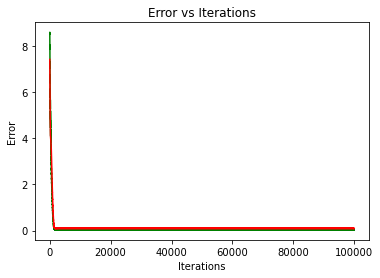

weights are: [ 3.91541067  0.35384341  0.316346   -0.2302575 ]


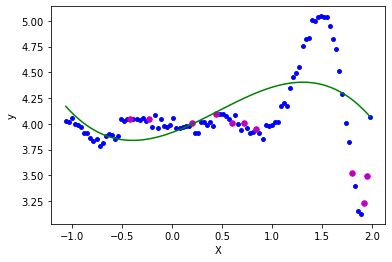

8.466113582043645
0.03612115488776225
0.03612143219057532
0.036121432366891776
0.0361214323669864
0.03612143236698516
0.03612143236698516
0.03612143236698516
0.03612143236698516
0.03612143236698516



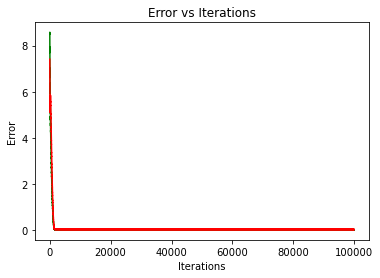

weights are: [ 3.88124453 -0.18835065  0.61529313  0.46880448 -0.39292954]


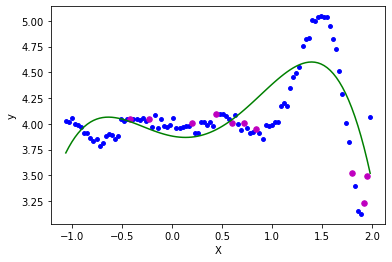

8.435329293721047
0.025005005520750054
0.024646661922424148
0.024626266460119114
0.024624702808065047
0.024624510776324562
0.024624483043804456
0.02462447892017682
0.02462447830425774
0.024624478212199798



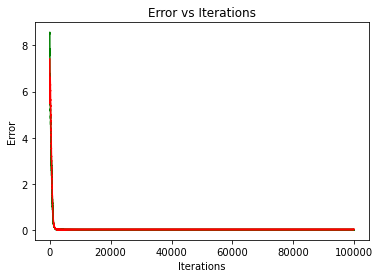

weights are: [ 4.02547165 -0.22190486 -0.51694734  0.77919974  0.59572656 -0.45670747]


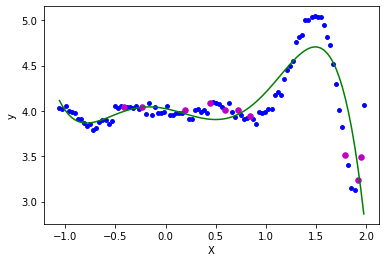

8.377862475266996
0.028245537316926923
0.02676576485084579
0.026038505628394378
0.025603839513395087
0.02531264422140093
0.02510458793208927
0.024950770801245317
0.02483507711477926
0.024747344307285146



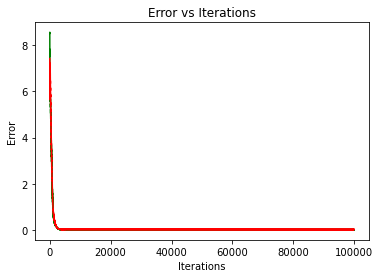

weights are: [ 4.03488509 -0.24132295 -0.53924281  0.88520862  0.59795769 -0.54558543
  0.03153668]


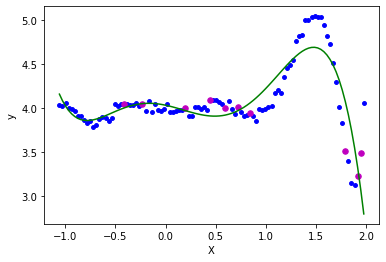

8.287471248199777
0.029924159730184505
0.028376467763392386
0.02756740906204952
0.026908663762402082
0.026332708530937707
0.025816710980144774
0.025349277970968226
0.02492329565439892
0.024533665871133842



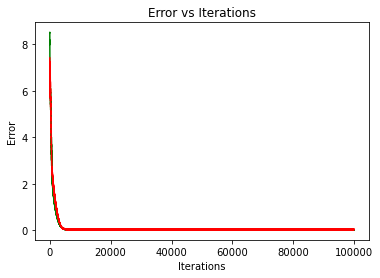

weights are: [ 4.00341171 -0.15388504 -0.42451829  0.49445323  0.81318429 -0.29165806
 -0.28135872  0.08657302]


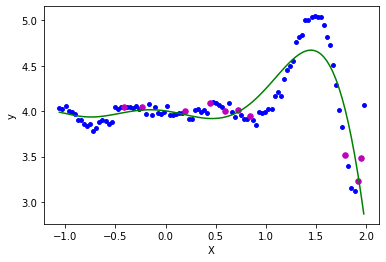

8.138866758490241
0.03297769494410143
0.028131566360433923
0.02560179341374573
0.02359567913610126
0.021994212591330622
0.02071926324905122
0.019706269453688776
0.018901621829817722
0.01826121630280288



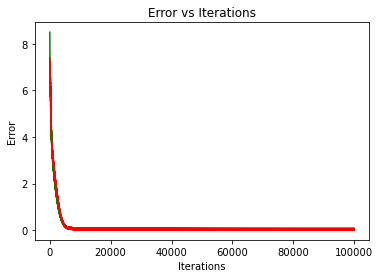

weights are: [ 4.01956566 -0.22040488 -0.41104043  0.31362158  0.34889874  0.67153819
 -0.0694529  -0.66226186  0.23812589]


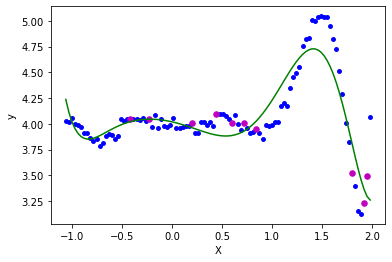

7.933535011702198
0.06527990728184731
0.029008078935124876
0.025800381629714094
0.02390728904357275
0.022296227708617136
0.020858210892525875
0.019569736673236287
0.018418461349668517
0.017393101798074708



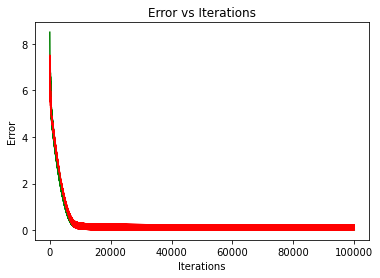

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254776]


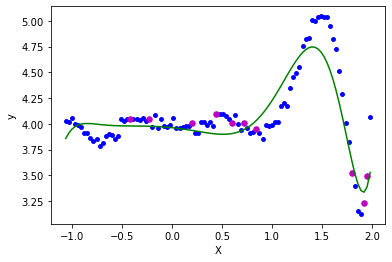

7.748071971049312
0.3869571087051083
0.0660050179831109
0.03854393319483548
0.031770276233012124
0.02834530415579538
0.025874417179993694
0.02386820978655971
0.022174233036081643
0.02072207605004051



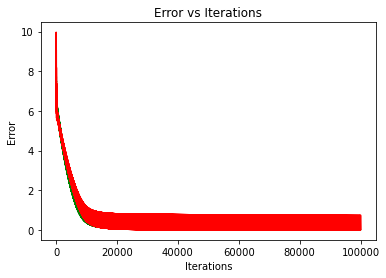

weights are: [ 3.89955918 -0.11098511  0.15376196 -0.00579246  0.0099376   0.23033704
  0.11854655  0.23046993 -0.175244   -0.20750551  0.10391787]


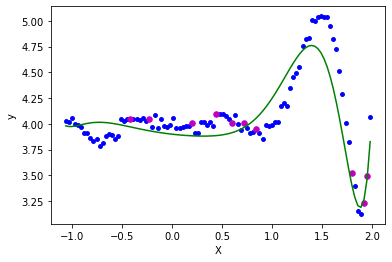

In [102]:
minerr = 999999
bestdeg = 0
testerrs = []
trainerrs = []
for MAX_POWER in range(3,11):
    trainerr,testerr = evaluate(dataset)
    testerrs.append(testerr)
    trainerrs.append(trainerr)
    if trainerr<minerr:
        minerr = trainerr
        bestdeg = MAX_POWER

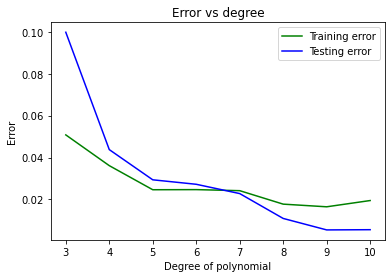

In [105]:
plt.clf()
plt.plot(np.arange(3,11),trainerrs,color='g',label = "Training error")
plt.plot(np.arange(3,11),testerrs,color='b',label = "Testing error")
plt.xlabel('Degree of polynomial')
plt.ylabel('Error')
plt.title('Error vs degree')
plt.legend()
plt.savefig(f"GD Error vs degree.png",dpi=1200)
plt.show()

13.676523679599677
1.2139769387076504
0.561942368406359
0.556026819035496
0.10994560031954731
0.09961047551819976
0.061846342171344534
0.008798784263831466
0.012866944387450304
0.04106672983879136



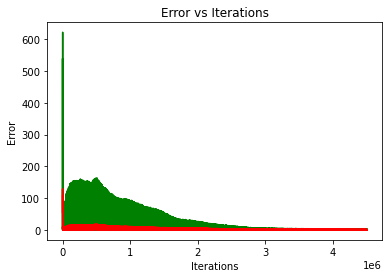

weights are: [ 3.96832055 -0.13573756  1.07340517  1.08750076 -5.04570011 -1.15167529
  6.66411332 -0.7004318  -2.64154578  0.86910988]


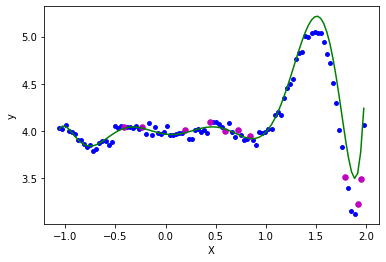

8.564680872565189
0.38374787834604596
0.21197416752468434
0.11150317755398341
0.2667214350643898
0.1020766177464231
0.1276863661790321
0.2439072184531935
0.15398440717934123
0.16661412503603232



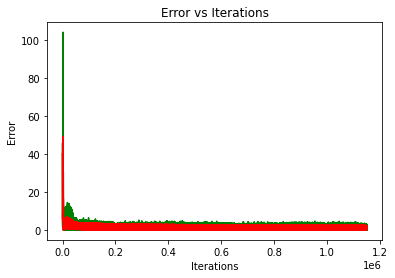

weights are: [ 4.00740858 -0.12950882  0.24016374  1.04520888 -2.23624326 -1.42933402
  3.39950396  0.11898749 -1.403174    0.37948672]


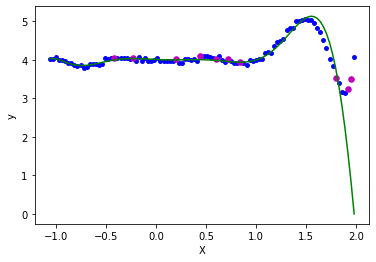

7.539410546527012
0.19520819194015535
0.21769928636678967
0.24594532198253308
0.2667050331962196
0.25208235703932286
0.14131195816563139
0.10441202617019853
0.10980982936604325
0.1291735222891428



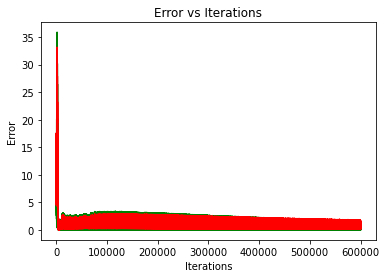

weights are: [ 3.98696898 -0.04158639  0.59997993 -0.08841182 -2.12887232  0.60726792
  1.98363562 -0.61711914 -0.44845286  0.14501592]


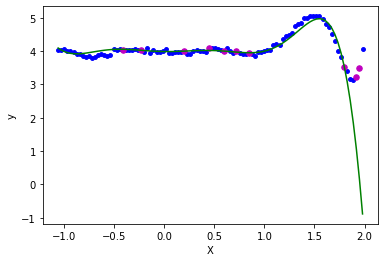

7.561643773755029
0.5756568396720544
0.39307863884803435
0.24733282267222204
0.11211476732818666
0.06750661290616009
0.09141793687321928
0.09470390919076052
0.0962085641469431
0.09355156907427592



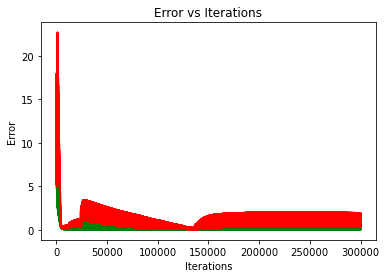

weights are: [ 4.02403717 -0.04878595 -0.29192498 -0.01136461 -0.23564204  0.28006419
  0.78380541 -0.26966429 -0.23900308  0.07300633]


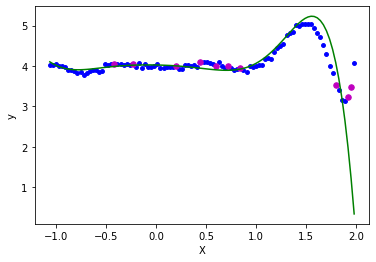

7.933535011702198
0.06527990728184731
0.029008078935124876
0.025800381629714094
0.02390728904357275
0.022296227708617136
0.020858210892525875
0.019569736673236287
0.018418461349668517
0.017393101798074708



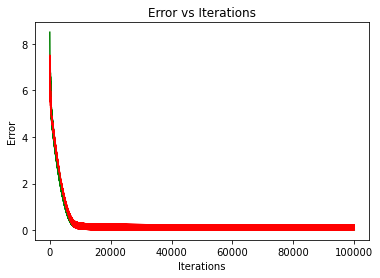

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254776]


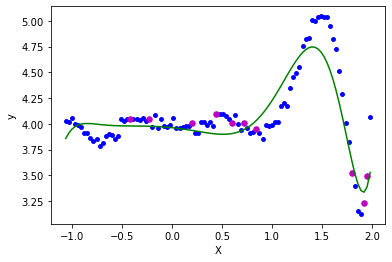

8.19639236254835
0.7686831683138885
0.2456729680637587
0.14365300673404008
0.1002202824295138
0.07545851016244062
0.06049920566460879
0.0513098171316928
0.04558082441302001
0.04193512697931033



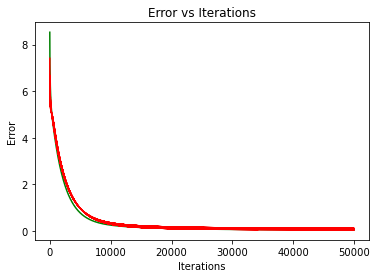

weights are: [ 3.74372686 -0.06956264  0.48151665  0.03372636  0.15251295  0.1059963
  0.02846179  0.00690867 -0.20210844  0.08150454]


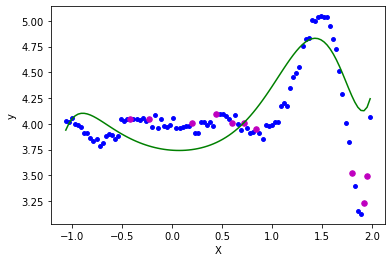

In [106]:
minerr = 999999
bestbs = 0
testerrs = []
trainerrs = []
MAX_POWER = 9
for BATCH_SIZE in [1,4,8,16,64,90]:
    trainerr,testerr = evaluate(dataset)
    testerrs.append(testerr)
    trainerrs.append(trainerr)
    if trainerr<minerr:
        minerr = trainerr
        bestbs = BATCH_SIZE

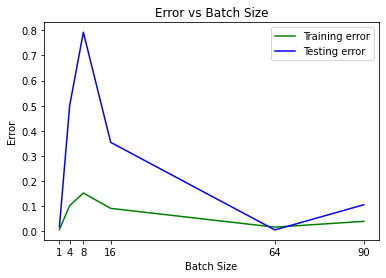

In [111]:
plt.clf()
ax = plt.axes()

plt.plot([1,4,8,16,64,90],trainerrs,color='g',label = "Training error")
plt.plot([1,4,8,16,64,90],testerrs,color='b',label = "Testing error")
plt.xlabel('Batch Size')
plt.ylabel('Error')
plt.xticks([1,4,8,16,64,90],('1','4','8','16','64','90'))
plt.title('Error vs Batch Size')
plt.legend()
plt.savefig(f"GD Error vs batch size.png",dpi=1200)
plt.show()

7.933535011702198
0.0652799072818685
0.029008078935132093
0.025800381629717897
0.023907289043576918
0.022296227708621167
0.02085821089252842
0.01956973667322727
0.018418461349664787
0.017393101798078087



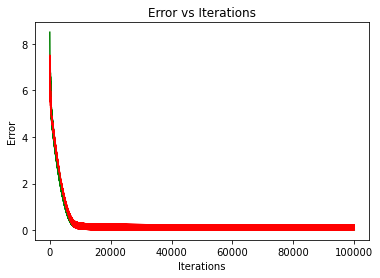

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254776]


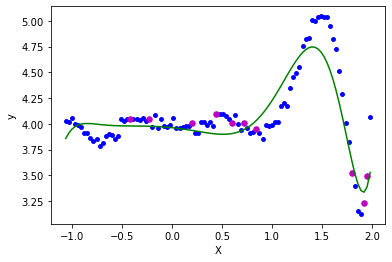

7.933535011702198
0.06527990728205921
0.0290080789351891
0.025800381629762295
0.023907289043622198
0.022296227708681757
0.020858210892604007
0.019569736673325785
0.018418461349777572
0.01739310179821066



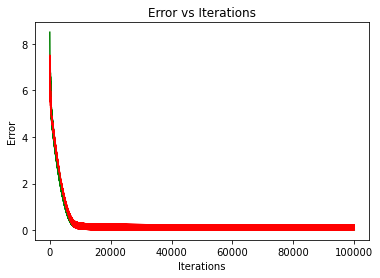

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254776]


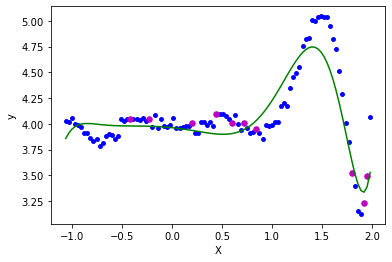

7.933535011702198
0.06527990728396188
0.029008078935765545
0.025800381630205666
0.023907289044133764
0.022296227709315986
0.020858210893404363
0.019569736674308925
0.018418461350950124
0.017393101799559812



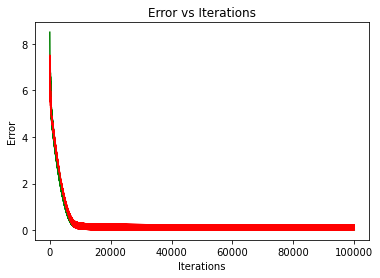

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254776]


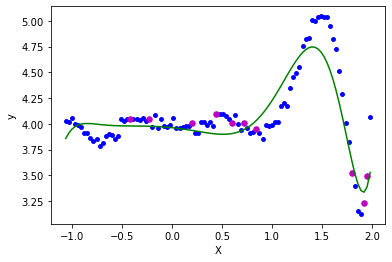

7.933535011702198
0.06527990730298866
0.0290080789415324
0.025800381634662525
0.023907289049249134
0.02229622771574369
0.02085821090142532
0.019569736684072445
0.01841846136250098
0.01739310181288909



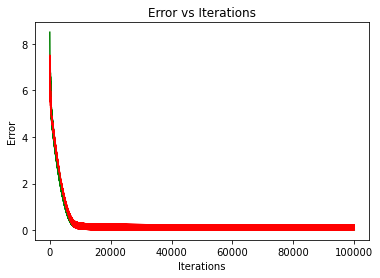

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254775]


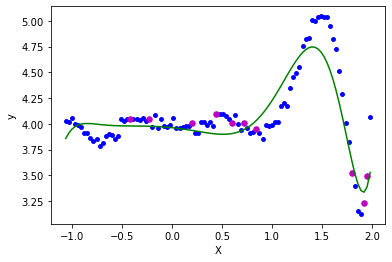

7.933535011702198
0.06527990749324841
0.029008078999194758
0.025800381679184633
0.02390728910038385
0.02229622777992739
0.02085821098161496
0.019569736781670077
0.018418461477990186
0.01739310194612126



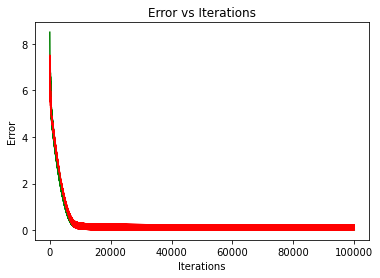

weights are: [ 3.96236658 -0.09910735 -0.17025343  0.0041804   0.22834292  0.31578346
  0.42731358 -0.24369878 -0.36161919  0.16254775]


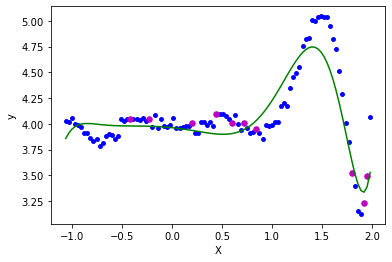

7.933535011702198
0.06527990939585226
0.02900807957582711
0.02580038212442292
0.02390728961172115
0.022296228421791624
0.020858211783535995
0.01956973775773869
0.01841846263299433
0.017393103278622292



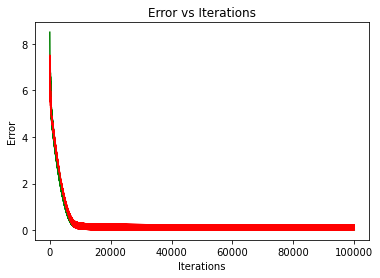

weights are: [ 3.96236655 -0.09910735 -0.17025335  0.0041804   0.22834291  0.31578344
  0.42731353 -0.24369875 -0.36161917  0.16254774]


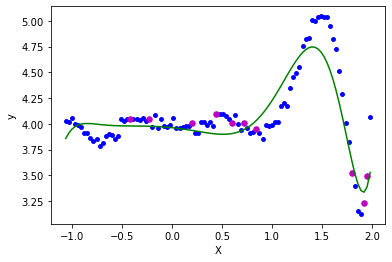

7.933535011702199
0.06527992842190103
0.02900808534214515
0.025800386576821648
0.02390729472505704
0.022296234840383313
0.02085821980267647
0.0195697475183208
0.018418474182957948
0.01739311660344167



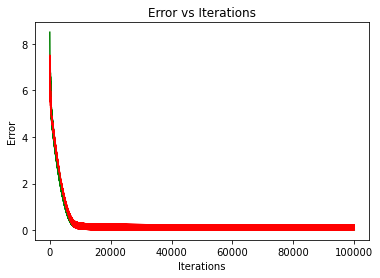

weights are: [ 3.96236623 -0.09910729 -0.17025256  0.00418046  0.22834282  0.31578318
  0.42731301 -0.24369846 -0.36161896  0.16254764]


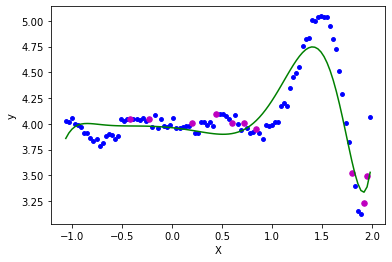

7.9335350117022045
0.06528011868282979
0.029008143006026835
0.02580043110157853
0.02390734585919535
0.02229629902700343
0.02085829999477238
0.019569845124886777
0.018418589683192807
0.017393249852243574



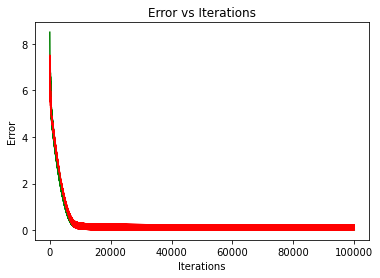

weights are: [ 3.96236304 -0.09910676 -0.17024471  0.00418105  0.2283419   0.31578057
  0.42730781 -0.24369557 -0.36161684  0.16254663]


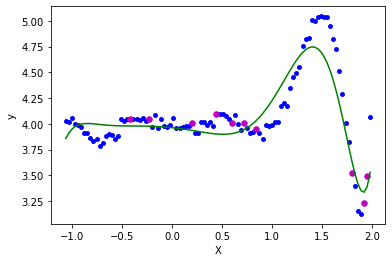

7.933535011702253
0.06528202133723059
0.029008719714280894
0.02580087642629083
0.023907857278725943
0.022296940968388333
0.020859101985033365
0.01957082125274425
0.018419744741142382
0.01739458239087426



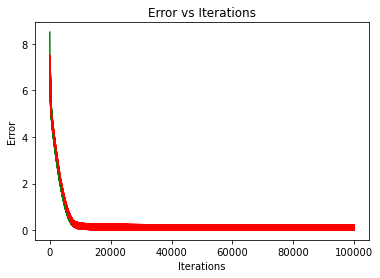

weights are: [ 3.9623311  -0.09910144 -0.17016618  0.00418693  0.22833275  0.31575455
  0.42725581 -0.24366672 -0.36159565  0.16253647]


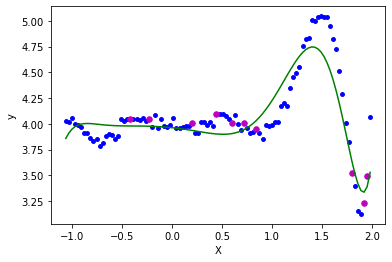

7.9335350117027374
0.06530105239170116
0.029014493740792638
0.025805337388624942
0.023912979284276506
0.022303367885413868
0.020867128808852508
0.01958058875294004
0.01843130087687857
0.01740791283001332



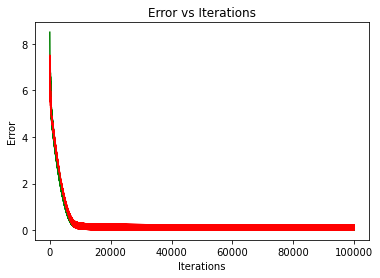

weights are: [ 3.96201182 -0.09904823 -0.16938139  0.00424564  0.22824136  0.31549451
  0.42673619 -0.24337841 -0.36138389  0.16243494]


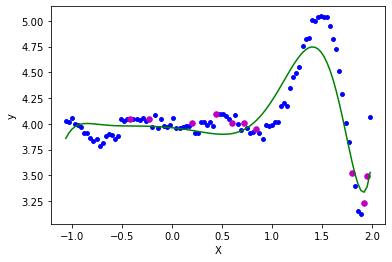

7.9335350117075905
0.06549181367028153
0.029072928274255744
0.025850718678334408
0.02396498059657844
0.022368387738072624
0.02094808963912062
0.019678886221709383
0.018547417436444762
0.01754172053851996



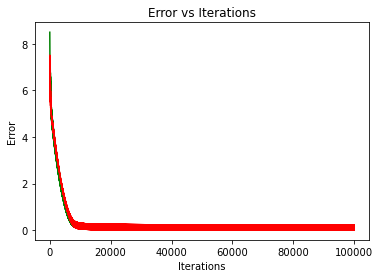

weights are: [ 3.95882442 -0.09851491 -0.16158304  0.00482666  0.22733847  0.31290962
  0.4215818  -0.24052195 -0.35927824  0.16142621]


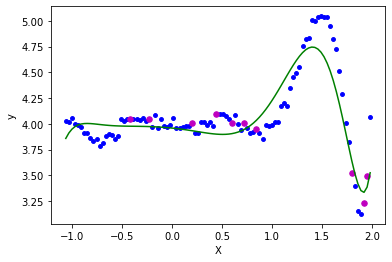

7.933535011756103
0.06744418948679531
0.029726571977653053
0.02638184949422001
0.02456335410432597
0.02309400452048716
0.021827399750437355
0.020724401653612303
0.019763746982214187
0.018928365205668637



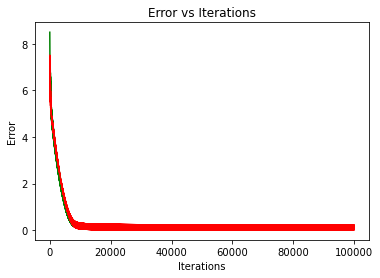

weights are: [ 3.92748227 -0.09312017 -0.08829464  0.01008074  0.21935007  0.28854692
  0.37397263 -0.21444955 -0.33935707  0.15195795]


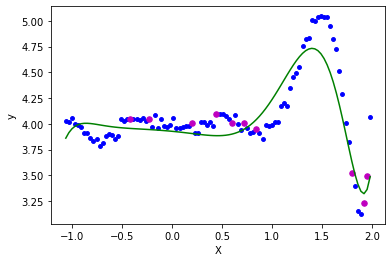

In [11]:
minerr = 999999
bestlambd = 0
testerrs = []
trainerrs = []
MAX_POWER = 9
BATCH_SIZE = 64
for REGULARIZATION_LAMBDA in [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]:
    trainerr,testerr = evaluate(dataset)
    testerrs.append(testerr)
    trainerrs.append(trainerr)
    if trainerr<minerr:
        minerr = trainerr
        bestlambd = REGULARIZATION_LAMBDA

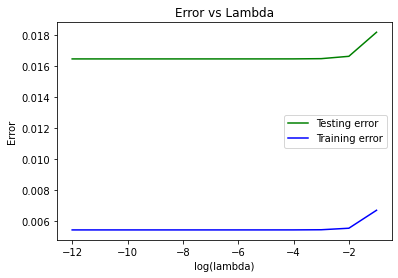

In [13]:
plt.clf()
plt.plot(np.arange(-12,0),trainerrs,color='g',label = "Testing error")
plt.plot(np.arange(-12,0),testerrs,color='b',label = "Training error")
plt.legend()
plt.xlabel("log(lambda)")
plt.ylabel("Error")
plt.title("Error vs Lambda")
plt.savefig('GD Error vs Lambda.png',dpi=1200)
plt.show()

7.933535011702198
0.06527990728184731
0.029008078935124876
0.025800381629714094
0.02390728904357275
0.022296227708617136
0.020858210892525875
0.019569736673236287
0.018418461349668517
0.017393101798074708



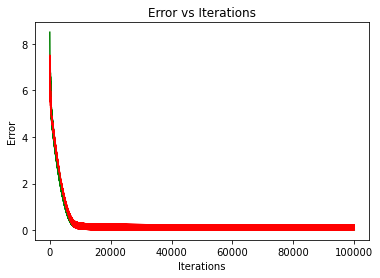

weights are: [ 3.96236659 -0.09910735 -0.17025344  0.0041804   0.22834292  0.31578347
  0.42731359 -0.24369878 -0.36161919  0.16254776]


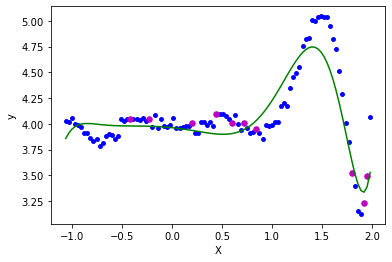

(0.01648250219182721, 0.0054500001946714335)

In [17]:
BATCH_SIZE = 64
MAX_POWER = 9
REGULARIZATION_LAMBDA = 0
evaluate(dataset)

In [128]:
def evaluate_moorepenrose(dataset,MAX_POWER):
    folds = cross_validation_split(dataset)
    err_list = []
    best_testerr = 99999999
    corr_trainerr = 9999999
    bestw = []
    for j,fold in enumerate(folds):
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        X = makeDesignMat(trainX,MAX_POWER)
        #w = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),trainY))
        w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
        plt = plot_reg(trainX,trainY,testX,testY,w)
        plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
        trainerr = testError(trainX,trainY,w,MAX_POWER)
        testerr = testError(testX,testY,w,MAX_POWER)
        if testerr<best_testerr and trainerr<testerr:
            best_testerr = testerr
            corr_trainerr = trainerr
            bestw = w
        #err_list.append([trainerr,testerr])
    #err_list = np.array(err_list)
    #avg_trainerror = np.mean(err_list[:,0])
    #avg_testerror = np.mean(err_list[:,1])
    #print(w)
    #print(err_list)
    return bestw,best_testerr,corr_trainerr

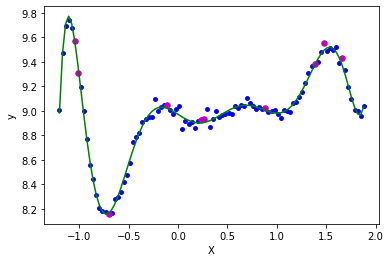

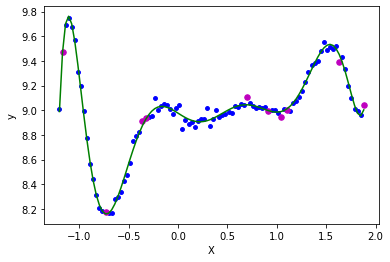

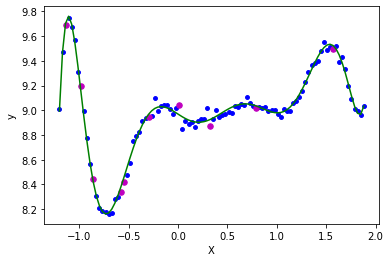

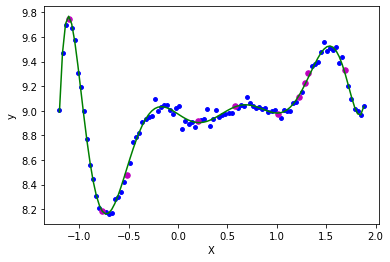

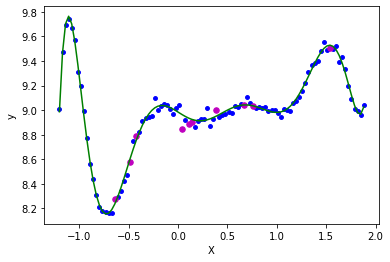

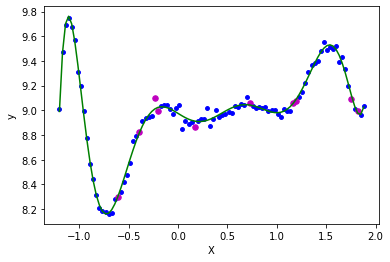

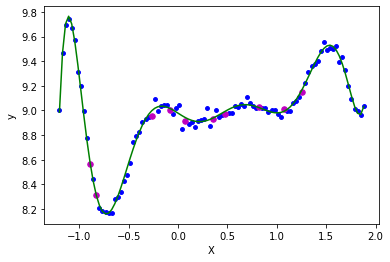

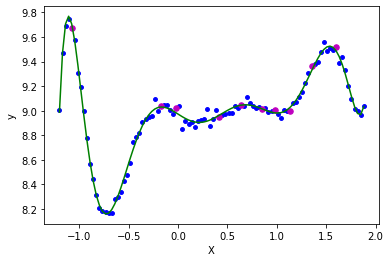

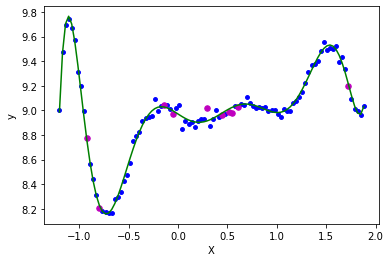

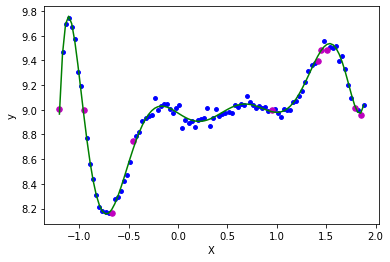

(array([ 8.97547675, -0.4938511 , -0.02974298,  5.43424352, -4.89995808,
        -7.20662444,  8.81990499,  1.10358338, -3.73607757,  1.01382973]),
 0.0005910737577133748,
 0.0005238645524446297)

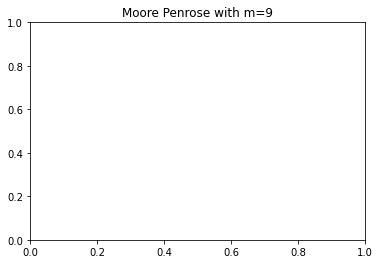

In [132]:
evaluate_moorepenrose(dataset,9)

In [16]:
def plotData(dataset):
    dataset = np.array(dataset)
    X = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(X,y,color="b",marker='o',s=20)
    plt.ylabel('t')
    plt.xlabel('x')
    plt.title(f'Gaussian Noise Dataset n={SUBSET} points')
    plt.show
    #plt.savefig(f'Gaussian Noise Dataset_{SUBSET}.png',dpi=1200)

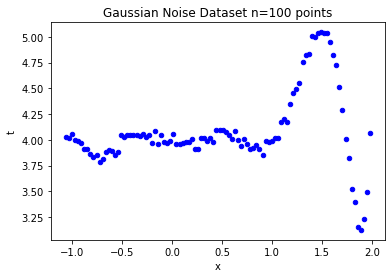

In [17]:
plotData(dataset)

In [240]:
def moorePenroseAnalysis(dataset):
    testerrlist = []
    trainerrlist = []
    for MAX_POWER in range(3,13):
        w,testerr,trainerr = evaluate_moorepenrose2(dataset,MAX_POWER)
        testerrlist.append(testerr)
        trainerrlist.append(trainerr)
    xa = np.arange(3,13)
    plt.clf()
    plt.plot(xa,trainerrlist,color='r',label="Training error")
    plt.plot(xa,testerrlist,color='b',label="Testing error")
    plt.legend()
    plt.savefig('Moore Penrose(Error vs m).png',dpi=1200)
    plt.show()

1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12


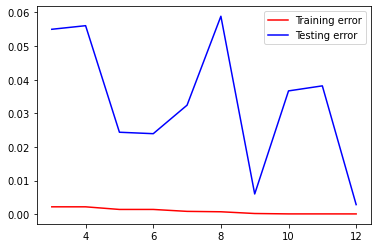

In [241]:
moorePenroseAnalysis(dataset)

In [209]:
def moorePenroseRegAnalysis(dataset):
    testerrlist = []
    trainerrlist = []
    global REGULARIZATION_LAMBDA
    for reg in [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]:
        REGULARIZATION_LAMBDA = reg
        w,testerr,trainerr = evaluate_moorepenrose2(dataset,9)
        testerrlist.append(testerr)
        trainerrlist.append(trainerr)
    xa = np.arange(-12,0)
    plt.clf()
    plt.plot(xa,trainerrlist,color='r',label="Training error")
    plt.plot(xa,testerrlist,color='b',label="Testing error")
    plt.legend()
    plt.xlabel("log(lambda)")
    plt.ylabel("Error")
    plt.title("Error vs Lambda")
    plt.savefig('Error vs Lambda.png',dpi=1200)
    plt.show()

1e-12
1e-11
1e-10
1e-09
1e-08
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1


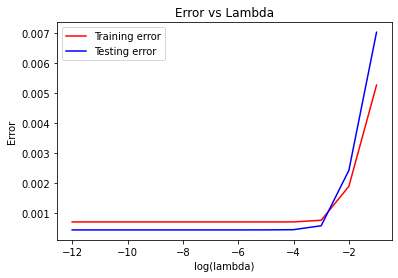

In [226]:
moorePenroseRegAnalysis(dataset)

In [18]:
def pseudoInv(X,t):
    pseudoInverse=np.linalg.pinv(X)
    weights=pseudoInverse @ t
    return(weights)

In [19]:
ds = np.array(dataset)
finw = pseudoInv(makeDesignMat(ds[:,0],9),ds[:,1])

In [230]:
def evaluate_moorepenrose2(dataset,MAX_POWER):
    dataset = np.array(dataset)
    trainDS = dataset[:18]
    testDS = dataset[18:]
    trainX = trainDS[:,0]
    trainY = trainDS[:,1]
    testX = testDS[:,0]
    testY = testDS[:,1]
    X = makeDesignMat(trainX,MAX_POWER)
    print(REGULARIZATION_LAMBDA)
    w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
    plt = plot_reg(trainX,trainY,testX,testY,w)
    plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
    trainerr = testError(trainX,trainY,w,MAX_POWER)
    testerr = testError(testX,testY,w,MAX_POWER)
    return w,testerr,trainerr

In [33]:
XX = makeDesignMat(ds[:,0],9)
pred = np.dot(XX,finw)
beta = len(ds[:,1])/(np.sum(np.square(pred-ds[:,1])))
1/beta

0.0013441315056887191

Mean of noise is: 1.0627942970131698e-13
Standard deviation of noise is: 0.036662399071647214
-0.07942198069926354 0.08833266771018389


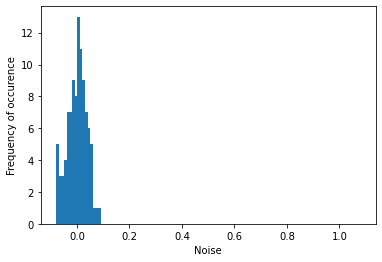

In [35]:
def getNoisePlot(trainX,trainY,w):
    trainX = makeDesignMat(trainX,MAX_POWER)
    preds = np.dot(trainX,w)
    noise = trainY-preds
    print(f"Mean of noise is: {np.mean(noise)}")
    print(f"Standard deviation of noise is: {np.std(noise)}")
    print(min(noise),max(noise))
    plt.clf()
    plt.hist(noise, bins=np.arange(noise.min(),noise.max()+1,0.01))
    plt.xlabel("Noise")
    plt.ylabel("Frequency of occurence")
getNoisePlot(ds[:,0],ds[:,1],finw)

7.933535011702198
0.06527990728184731
0.029008078935124876
0.025800381629714094
0.02390728904357275
0.022296227708617136
0.020858210892525875
0.019569736673236287
0.018418461349668517
0.017393101798074708
0.01648233074583398
0.015675020965274518
0.014960549668551872
0.014328986862600406
0.013771184184402829
0.013278799519201138
0.012844283507463377
0.012460844392664459
0.012122401175492868
0.011823531102287128
0.011559415177009704
0.011325783984126616
0.011118865248628875
0.01093533401229826
0.010772265944766338
0.010627094064074506
0.010497568971844713
0.010381722589554264
0.010277835299611154
0.01018440633836647
0.010100127251488214
0.010023858199840844
0.009954606893302775
0.009891509927573152
0.009833816302824216
0.009780872911135564
0.009732111790927395
0.009687038959738074
0.009645224650906168
0.009606294793966148
0.009569923593650968
0.009535827075744538
0.009503757481978499
0.009473498408471018
0.009444860593861116
0.0094176782738493
0.009391806028938174
0.009367116060683666
0.

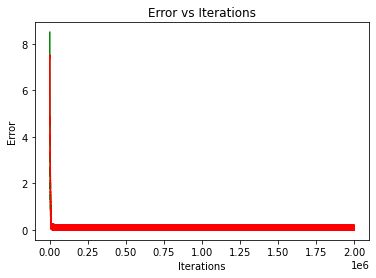

weights are: [ 4.06691207  0.12881184 -0.51140171 -0.58149609 -0.55112803  0.80030634
  2.0366872  -0.7689553  -1.01241879  0.42429773]


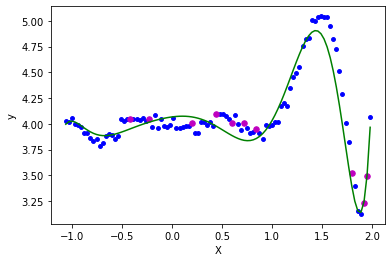

(0.007716105577904854, 0.0045576636079770316)

In [25]:
BATCH_SIZE = 64
MAX_POWER = 9
NUM_ITER = 1000000
REGULARIZATION_LAMBDA = 0
ERROR = "mse"
evaluate(dataset)

8.340999579049683
5.05435286871186
4.324859962719366
3.5638647775770704
2.864909850149391
2.2506217573978633
1.7304898199694878
1.2900488080306804
0.9460602514929594
0.7143306234296375
0.5624592385188644
0.4507280207073032
0.366859874124089
0.3027976903491401
0.2518366565758937
0.21241101782321306
0.17937392570647454
0.15110076131887243
0.1282782947700052
0.10911250226563027
0.09632036919679912
0.08329078010465216
0.07043720651233876
0.06114892503133494
0.054584635824537535
0.04643980295094844
0.041543014307706266
0.04299852344097975
0.03936000765037398
0.03923291834447638
0.0378428555538627
0.039685145370950754
0.039228213588897845
0.041923930453658616
0.04630505342170148
0.054135922614379675
0.05290972557503276
0.05668880054858145
0.05460058677110258
0.05727628231525486
0.05893928515627983
0.05542805261590671
0.058601049326048864
0.05974279333613776
0.059987992228345555
0.06313706982344844
0.06706182681470023
0.06889490460877878
0.06851908125531812
0.06839463690868014
0.0639587340089

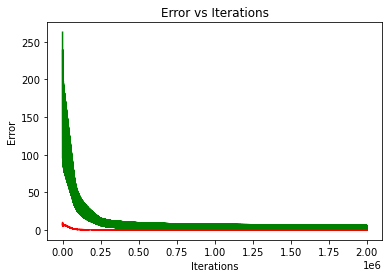

weights are: [ 4.05653438 -0.00454083 -0.68702174 -0.18186197  0.21632195  0.44456308
  0.97800974 -0.45051487 -0.52573018  0.2242866 ]


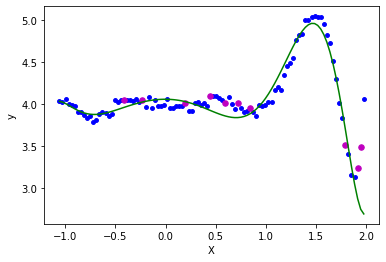

(0.014430131610707964, 0.04035989362065932)

In [30]:
BATCH_SIZE = 64
MAX_POWER = 9
NUM_ITER = 1000000
LEARNING_RATE = 0.00003
REGULARIZATION_LAMBDA = 0
ERROR = "mae"
evaluate(dataset)

711.6515594175095
0.3263750483784611
0.31250533197951386
0.1748423817159754
3.738446857616784
1.107430701456647
1.4208963088345758
0.02076342633638633
0.0198070648086575
0.976223429141531
0.025177333011192637
0.017475663869767975
0.7185130527712774
0.45502654340322896
0.022467701686656773
0.01582526823988881
0.24469817642309352
0.016523531356385592
0.4500514927713172
0.01431127782763911



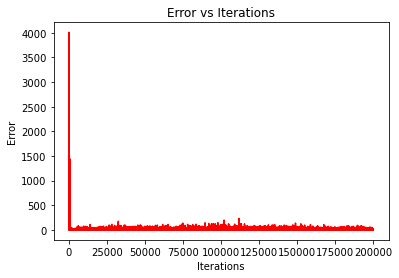

weights are: [ 4.05609636  0.01987331 -0.54243969 -0.14012847  0.11039433  0.35909019
  0.79302613 -0.3815608  -0.37536046  0.17038981]


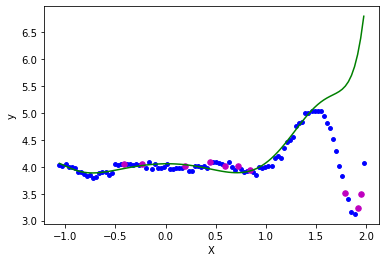

(0.1866222709752176, 1.0250308642061898)

In [34]:
BATCH_SIZE = 64
MAX_POWER = 9
NUM_ITER = 100000
LEARNING_RATE = 0.003
REGULARIZATION_LAMBDA = 0
ERROR = "huber"
evaluate(dataset)